In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd

In [2]:
tm_routes = gpd.read_file("gis/export/tm_routes_simplified.geojson")
tm_routes.head(3)

rte  dir  rte_desc public_rte                             dir_desc  \
0    1    0   Vermont          1  To Vermont & Shattuck and Maplewood   
1    1    1   Vermont          1              To Portland City Center   
2    2    0  Division        FX2                           To Gresham   

  frequent type rte_dir                                           geometry  
0    False  BUS     1_0  LINESTRING (-122.67740 45.52288, -122.67741 45...  
1    False  BUS     1_1  LINESTRING (-122.72190 45.47624, -122.72237 45...  
2     True  BUS     2_0  MULTILINESTRING ((-122.68003 45.51427, -122.68...

In [3]:
tm_routes_proj = tm_routes.to_crs("EPSG:2913")

In [4]:
# make distance same as trip planner config
tm_routes_proj['buffer_geometry'] = tm_routes_proj['geometry'].apply(lambda x: x.buffer(1600))

In [5]:
tm_routes_buffer = gpd.GeoDataFrame(tm_routes_proj.drop('geometry', axis=1), crs="EPSG:2913", geometry="buffer_geometry")

In [6]:
tm_routes_buffer_view = tm_routes_buffer.to_crs("EPSG:4326")

In [7]:
tm_routes_buffer_view.explore()

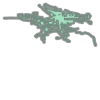

In [8]:
tm_routes_buffer_union = tm_routes_buffer_view.unary_union
tm_routes_buffer_union

In [9]:
tm_route_boundaries = pd.DataFrame([['trimet_route_buffer_boundary']],columns=['description'])
tm_route_boundaries_gpd = gpd.GeoDataFrame(tm_route_boundaries, crs="EPSG:4326", geometry=[tm_routes_buffer_union])

In [10]:
tm_route_boundaries_gpd.explore()

In [12]:
#currently neighborhood dataset is manually downloaded from https://gis-pdx.opendata.arcgis.com/datasets/PDX::neighborhoods-regions/about
#note to self how do you find the api dataset id??
pdx_neighborhoods = gpd.read_file("gis/export/Neighborhoods_(Regions).geojson")
pdx_neighborhoods.head(3)

OBJECTID             NAME COMMPLAN SHARED COALIT HORZ_VERT  \
0         1   CATHEDRAL PARK                   NPNS      HORZ   
1         2  UNIVERSITY PARK                   NPNS      HORZ   
2         3         PIEDMONT   ALBINA          NPNS      VERT   

          MAPLABEL  ID  Shape_Length    Shape_Area  \
0   Cathedral Park  31  11434.254777  5.424298e+06   
1  University Park  88  11950.859827  6.981457e+06   
2         Piedmont  70  10849.327392  6.079530e+06   

                                            geometry  
0  POLYGON ((-122.74774 45.57642, -122.74500 45.5...  
1  POLYGON ((-122.70796 45.57496, -122.70797 45.5...  
2  POLYGON ((-122.67545 45.58659, -122.67593 45.5...

In [13]:
pdx_neighborhoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
tm_route_boundaries_gpd.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
tm_route_boundaries_gpd.to_file("gis/export/tm_route_buffer_bounds.geojson", driver="GeoJSON")

In [16]:
tm_route_boundaries_clipped = gpd.clip(tm_route_boundaries_gpd, pdx_neighborhoods.unary_union)

/Users/benjaminmalnor/.pyenv/versions/miniconda3-latest/envs/geo-analysis/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [17]:
tm_route_boundaries_clipped.explore()

In [18]:
tm_route_boundaries_clipped.to_file("gis/export/tm_route_buffer_bounds_clipped.geojson", driver="GeoJSON")